# Импорт библиотек и функций

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
import numpy as np
import seaborn as sns
import scipy.stats as st
import warnings
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
warnings.filterwarnings('ignore')

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.

**Цель работы:**

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
try:
  taxi=pd.read_csv('/datasets/taxi.csv')
except:
  taxi=pd.read_csv('/content/taxi.csv')

In [ ]:
taxi.info()
taxi.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
21466,2018-07-28 01:40:00,25
8142,2018-04-26 13:00:00,11
14986,2018-06-13 01:40:00,11


- отсутствуют пропуски в данных
- параеметр datetime имеет не соответствующий тип данных object

In [ ]:
print('Кол-во явных дублиатов: ', taxi.duplicated().sum())

Кол-во явных дублиатов:  0


In [ ]:
df = taxi.copy()

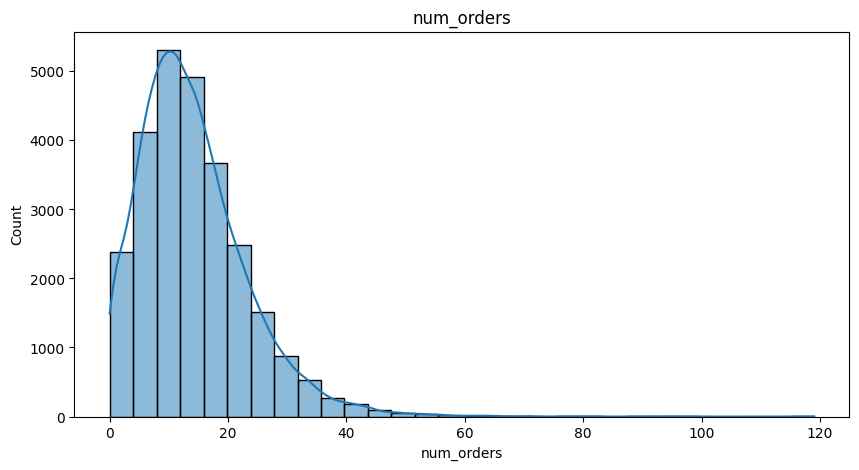

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.histplot(df['num_orders'], kde=True, bins=30).set_title('num_orders');

- графический наблюдается распределение Пауссона
- в num_orders остутвуют выбросы и аномальные значения

**Вывод по разделу**

- отсутствуют пропуски в данных
- параеметр datetime имеет не соответствующий тип данных object
- отсутствуют дубликаты данных
- графический наблюдается распределение Пауссона
- в num_orders остутвуют выбросы и аномальные значения
- данные в датасете соответствуют описанию данных

## Анализ

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
df.set_index('datetime', drop=True, inplace=True);

- проверим данные на монохромность и перестроим порядок в случае её отсутствия

In [ ]:
if df.index.is_monotonic == True:
    print('Данные монохромные')
else:
    df.sort_index(inplace=True)

Данные монохромные


In [ ]:
print('Изучаемый промежуток времени с ', df.index.min(), 'по', df.index.max())

Изучаемый промежуток времени с  2018-03-01 00:00:00 по 2018-08-31 23:50:00


- так как нас инетресует кол-во заказов в час, то проведем ресемплирования с агрегацией по сумме

In [ ]:
df = df.resample('1H').sum()
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


- оценим тренд и сезонность кол-ва заказо в час, поскольку общий интервал данных (6 месяцев) значительно превышает интервал предсказаний (1 час), то чтобы избежать высокой частоты изменений и оценить общий тренд оценим его разбив данные по дням и используя среднее количество заказов в час

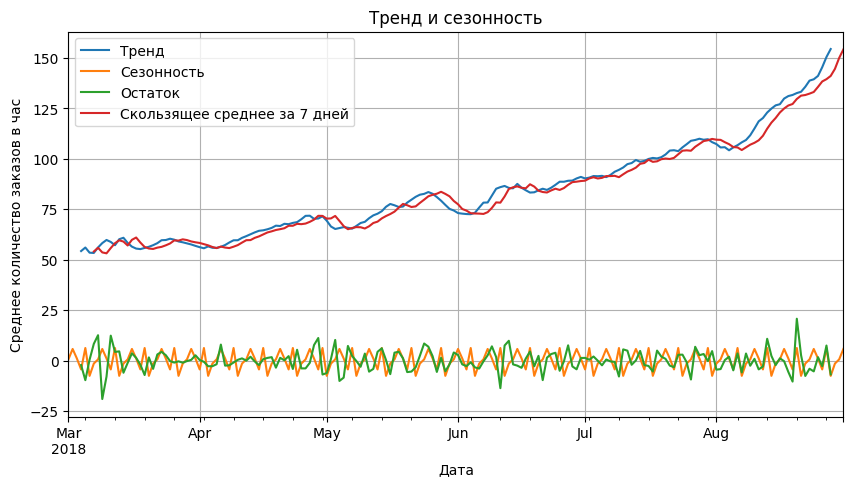

In [ ]:
decomposed = seasonal_decompose(df.resample('1D').mean())
decomposed.trend.plot(ax=plt.gca())
decomposed.seasonal.plot(ax=plt.gca())
decomposed.resid.plot(ax=plt.gca())
df.shift(1).resample('1D').mean().rolling(7).mean().plot(ax=plt.gca())
plt.legend(['Тренд', 'Cезонность', 'Остаток', 'Скользящее среднее за 7 дней'])
plt.title('Тренд и сезонность')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Дата')
plt.grid(True);

- наблюдается растущий тренд

- скользящее срднее растет, следственно ряд нестационарный

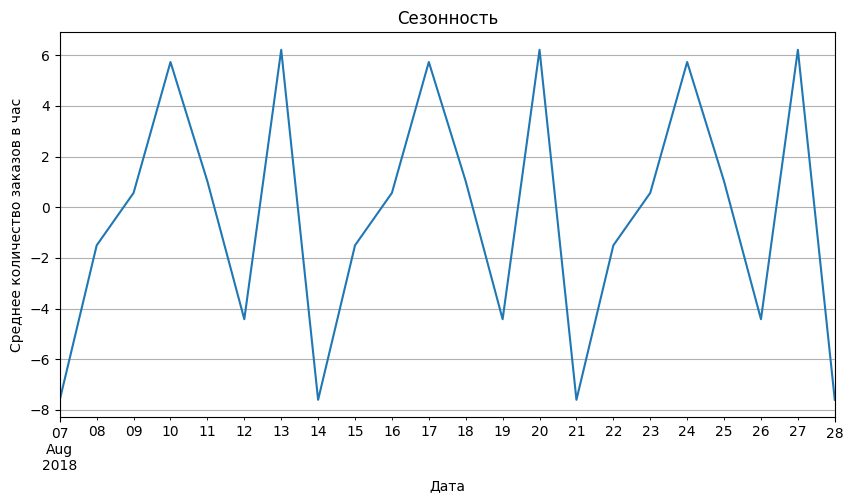

In [ ]:
decomposed.seasonal.loc['2018-08-7':'2018-08-28'].plot(ax=plt.gca());
plt.title('Сезонность')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Дата')
plt.grid(True);

- графический анализ показал, что период сезонности составляет 7 дней

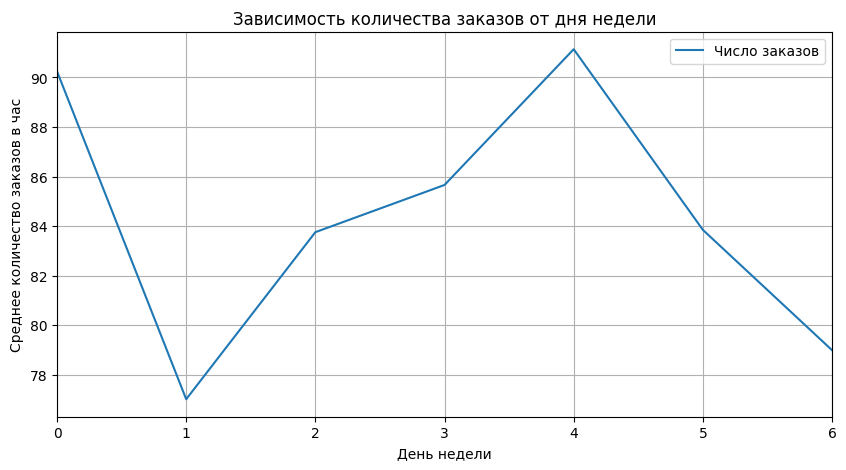

In [ ]:
df.groupby(df.index.dayofweek).mean().plot()
plt.xlim(0, 6)
plt.title('Зависимость количества заказов от дня недели')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('День недели')
plt.legend(['Число заказов'])
plt.grid(True);

- в понедельник и пятницу наибольшее количество заказов, тогда как во вторник и воскресенье наименьшее

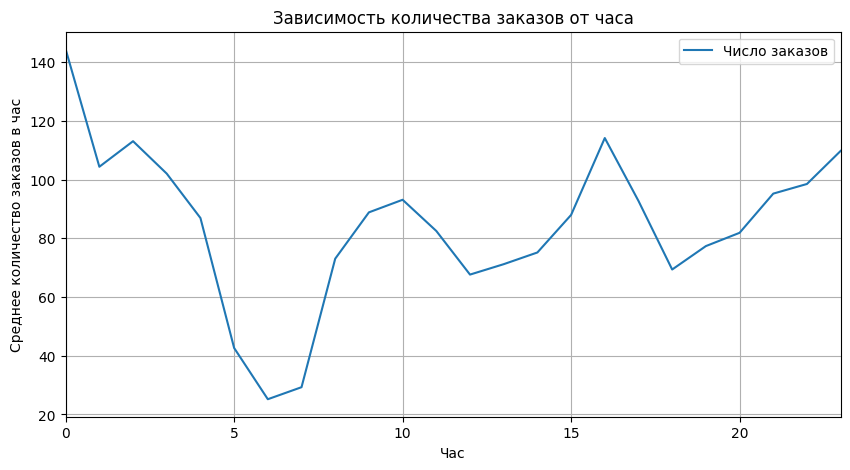

In [ ]:
df.groupby(df.index.hour).mean().plot()
plt.xlim(0, 23)
plt.legend(['Число заказов'])
plt.title('Зависимость количества заказов от часа')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Час')
plt.grid(True)

- наибольшее число заказов ночью после 20 и до 4, в утреннее время с 8 до 10 и вечернее с 16 до 18

**Выводы по разделу**

- проверены данные на монохромность
- проведено ресемплирования с агрегацией по сумме
- проведена оценка тренда и сезонности кол-ва заказо в час
- наблюдается растущий тренд
- скользящее срднее растет, следственно ряд нестационарный
- период сезонности составляет 7 дней
- в понедельник и пятницу наибольшее количество заказов, тогда как во вторник и воскресенье наименьшее
- наибольшее число заказов ночью после 20 и до 4, в утреннее время с 8 до 10 и вечернее с 16 до 18
- так как наша задача о заказах такси в аэропортах можно предположить, что тренд роста к лету вероятно связан с летними и осенними отпусками
- сезонность понедельника и пятницы объясняется тем, что отпуск часто для начала отпуска выбрают понедельник, поэтому прелёты более активны после рабочего дня в пятницу, на выходных или в понедельник. Однако на выходных больше времени и возможности добраться на другом транспорте, поэтому в субботу и воскресенье спрос на такси снижен.
- наиболее популярны ночные, вечерние и утрении перелёты, это связано с временем работы большинства людей

## Обучение

- для оптимизации создания расчетной модели, созданим функцию для создания новых признаков

In [ ]:
def create_features(data, num_of_shifts, size_of_rolling):
    # создадим признак определяющий день недели
    data['dayofweek'] = data.index.dayofweek
    # создадим признак определяющий час
    data['hour'] = data.index.hour
    # создадим признак определяющий общий тренд с отставанием на один шаг, чтобы издежать включения искомого значения
    data['trend'] = data['num_orders'].shift(1).rolling(24*7).mean()
    data['trend'].fillna(data['num_orders'].shift(1).rolling(size_of_rolling).mean(), inplace=True)
    # создадим несколько признаков прошлых измерений используя цикл и смещение данных
    for i in range(num_of_shifts):
        data['lag_' + str(i+1)] = data['num_orders'].shift(i+1)
    # создадим признак скользящего среднего с отставанием на один шаг, чтобы издежать включения искомого значения
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(size_of_rolling).mean()
    # удалим строки с отсутствующими признаками
    return data.dropna()

In [ ]:
df_learn = create_features(df, 7, 7)
df_learn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4409 entries, 2018-03-01 07:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4409 non-null   int64  
 1   dayofweek     4409 non-null   int64  
 2   hour          4409 non-null   int64  
 3   trend         4409 non-null   float64
 4   lag_1         4409 non-null   float64
 5   lag_2         4409 non-null   float64
 6   lag_3         4409 non-null   float64
 7   lag_4         4409 non-null   float64
 8   lag_5         4409 non-null   float64
 9   lag_6         4409 non-null   float64
 10  lag_7         4409 non-null   float64
 11  rolling_mean  4409 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 447.8 KB


In [ ]:
df_learn.sample(2)

,num_orders,dayofweek,hour,trend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,
2018-07-19 02:00:00,152,3,2,98.559524,96.0,125.0,128.0,74.0,127.0,109.0,104.0,109.0
2018-08-25 11:00:00,103,5,11,133.511905,126.0,196.0,108.0,22.0,74.0,118.0,196.0,120.0


In [ ]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(df_learn.drop(['num_orders'], axis=1),
                                                    df_learn['num_orders'],
                                                    shuffle=False,
                                                    test_size=0.1,
                                                    random_state=RANDOM_STATE)
tss = TimeSeriesSplit(n_splits=5)

In [ ]:
# Обучение модели линейной регрессии
params = {}

model_lr = RandomizedSearchCV(estimator=LinearRegression(fit_intercept=False, positive=True),
                              scoring='neg_root_mean_squared_error', param_distributions=params, cv=tss, n_jobs=-1)
model_lr.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', model_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -(model_lr.best_score_))

Лучшая модель и её параметры:

 LinearRegression(fit_intercept=False, positive=True)
Метрика лучшей модели на тренировочной выборке: 31.620910172968088


In [ ]:
# Обучение модели рандомного леса
params = {
    'max_depth': [None] + [i for i in range(2, 7)],
    'max_features': range(2, 100),
    'max_leaf_nodes': range(2, 100),
}

model_RFR= RandomizedSearchCV(estimator=RandomForestRegressor(random_state=RANDOM_STATE),  param_distributions=params,
                              scoring='neg_root_mean_squared_error', n_jobs=-1, n_iter=50, cv=tss)
model_RFR.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', model_RFR.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -(model_RFR.best_score_))

Лучшая модель и её параметры:

 RandomForestRegressor(max_features=30, max_leaf_nodes=94, random_state=42)
Метрика лучшей модели на тренировочной выборке: 25.443127023198663


In [ ]:
# Обучение модели CatBoost
params = {
    'iterations': [750, 800, 850],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS']
}
model_cb = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=RANDOM_STATE, verbose=0),
                              scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tss, param_distributions=params)
model_cb.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', model_cb.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -(model_cb.best_score_))

Лучшая модель и её параметры:

Метрика лучшей модели на тренировочной выборке: 26.11358150034374


In [ ]:
model_DR = DummyRegressor(strategy='mean')
model_DR.fit(X_train, y_train)

DummyRegressor()

**Вывод по разделу**

- CatBoost подходят для выбранной задачи лучше остальных моделей
- показания метрики CatBoost по результатам кроссвалидации RMSE 23.9 (ТЗ: RMSE <= 48)

## Тестирование

In [ ]:
predictions = model_cb.predict(X_test)
rmse =  mean_squared_error(y_test, predictions, squared=False)
print("Модель CatBoost RMSE = ", rmse)

Модель CatBoost RMSE =  44.80223258934748


In [ ]:
predictions = model_DR.predict(X_test)
rmse =  mean_squared_error(y_test, predictions, squared=False)
print("Константная модель RMSE = ", rmse)

Константная модель RMSE =  84.80263773864422


**Вывод по разделу**

- модель CatBoost адекватна и спраляется лучше чем константная модель
- CatBoost подходят для выбранной задачи и рекомендуются к использованию в этом и сходственных исследованиях

## Общий вывод

В данном проекте разработаны 3 модели для предсказания стоимости автомобиля

Данные были получены из файла /datasets/autos.csv. Перед началом исследовательской части был произведен обзор и проверка на адекватность полученных данных. Выявлено, что:

- отсутствуют пропуски в данных
- параеметр datetime имеет не соответствующий тип данных object
- отсутствуют дубликаты данных
- графический наблюдается распределение Пауссона
- в num_orders остутвуют выбросы и аномальные значения
- данные в датасете соответствуют описанию данных

На основе полученного датасета был проведен исследрвательский анализ, результатыты которого покзаывают, что:

- данные монохромны
- проведено ресемплирования с агрегацией по сумме
- проведена оценка тренда и сезонности кол-ва заказо в час
- наблюдается растущий тренд
- скользящее срднее растет, следственно ряд нестационарный
- период сезонности составляет 7 дней
- в понедельник и пятницу наибольшее количество заказов, тогда как во вторник и воскресенье наименьшее
- наибольшее число заказов ночью после 20 и до 4, в утреннее время с 8 до 10 и вечернее с 16 до 18
- так как наша задача о заказах такси в аэропортах можно предположить, что тренд роста к лету вероятно связан с летними и осенними отпусками
- сезонность понедельника и пятницы объясняется тем, что отпуск часто для начала отпуска выбрают понедельник, поэтому прелёты более активны после рабочего дня в пятницу, на выходных или в понедельник. Однако на выходных больше времени и возможности добраться на другом транспорте, поэтому в субботу и воскресенье спрос на такси снижен.
- наиболее популярны ночные, вечерние и утрении перелёты, это связано с временем работы большинства людей

Основываясь на полученных результатах исследования, проведено обучение моделей:

- выбраны 3 регрессионые модели (LinerRegression, RandomForestRegression, CatBoostRegression)
- для оптимизации создания расчетных моделей, разработана функция для создания новых признаков
- CatBoost подходят для выбранной задачи лучше остальных моделей
- показания метрики CatBoost по результатам кроссвалидации RMSE 23.9 (ТЗ: RMSE <= 48)

Тестирования подготовленой модели показало, что:

- модель CatBoost адекватна и спраляется лучше чем константная модель
- CatBoost подходят для выбранной задачи и рекомендуются к использованию в этом и сходственных исследованиях